# Leave-one-out cross validation

## Data

In [5]:
import pandas as pd
import numpy as np
import GPy
import matplotlib.pyplot as plt

def data_preprocessing_procedure(reference_time_series,
                                 target_experiments,
                                 filter_threshold = 10,
                                 epsilon = 0.1,
                                 epsilon_tukey = 10**(-5)):

    reference_time_series = reference_time_series.loc[reference_time_series.max(axis=1) >= filter_threshold] 

    common_genes = reference_time_series.index
    target_experiments = target_experiments.loc[common_genes]

    reference_time_series = np.log(reference_time_series + epsilon)

    i=0
    while True:

        i=i+1
        last_sum_ref = reference_time_series.abs().sum().sum()
        last_sum_target = target_experiments.abs().sum().sum()

        #subtract to each gene the median of the current experiment
        reference_time_series = reference_time_series.sub(reference_time_series.median(axis = 0),axis = 1)
        target_experiments = target_experiments.sub(target_experiments.median(axis = 0), axis = 1)

        #subtract to each gene the median over all experiments of that gene
        reference_time_series = reference_time_series.sub(reference_time_series.median(axis = 1),axis = 0)
        target_experiments = target_experiments.sub(target_experiments.median(axis = 1), axis = 0)

        ref_red = np.abs(reference_time_series.abs().sum().sum()-last_sum_ref)/reference_time_series.abs().sum().sum()
        
        target_red = np.abs(target_experiments.abs().sum().sum()-last_sum_target)/target_experiments.abs().sum().sum()

        if target_red < epsilon_tukey and ref_red < epsilon_tukey:
            break

    return reference_time_series, target_experiments, common_genes


reference_time_series = pd.read_csv("one_gene_operon_reference_experiments.csv", index_col=0)
target_experiments = pd.read_csv("target_experiments.csv", index_col=0)

reference_time_series, target_experiments, common_genes = data_preprocessing_procedure(reference_time_series, target_experiments)

## Unconstrained GPs

In [6]:
TIME_POINTS = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

X = np.array([[el] for el in TIME_POINTS]*3)

GP_LOO_nat_no_constr = []

length_scales_no_constr = []

gp_models_no_constr = {}
    
for gene, ind in zip(common_genes, range(1780)):

    Y = np.array([[a] for a in reference_time_series.loc[gene]])

    kernel = GPy.kern.RBF(input_dim=1, variance=0.5, lengthscale=4, useGPU=False)

    m = GPy.models.GPRegression(X,Y,kernel, normalizer=False)

    kernel.lengthscale.constrain_bounded(lower = 0, upper=100, warning=0)
    
    m.optimize(messages=False)
    
    length_scales_no_constr.append(m.kern.lengthscale[0])
    
    gp_models_no_constr[gene] = m
    
    loo = []
    
    for i in range(11):
        mask = np.array([False if j%11 == i else True for j in range(len(Y))])
        m_loo = GPy.models.GPRegression(X[mask],Y[mask],m.kern, normalizer=False)
        loo.append(m_loo.log_predictive_density(np.array([[TIME_POINTS[i]]]), Y[~mask]).sum())

    GP_LOO_nat_no_constr.append(loo)

    # ==== side-by-side plots ====
    '''fig, axes = plt.subplots(1, 2, figsize=(6, 3))

    # ── left: GP fit ───────────────────────────────────────────────
    m.plot(ax=axes[0], legend=False)     # GP mean & ±2 s.d. band
    axes[0].set_title(f"GP marg. log-lik:{np.round(m.log_likelihood())}", fontsize=10)
    axes[0].set_xlabel("Time (h)", fontsize=10)
    axes[0].set_ylabel("Expression", fontsize=10)

    # ── right: LOO densities ──────────────────────────────────────
    axes[1].plot(X[:11], loo, marker='o')
    axes[1].set_title("LOO log-predictive density", fontsize=10)
    axes[1].set_xlabel("Time (h)", fontsize=10)
    axes[1].set_ylabel("Σ log p(yᵢ | y₋ᵢ)", fontsize=10)

    fig.suptitle(f"({ind+1}) Gene: {gene}\n Sum LOO:{sum(loo)} | λ={np.round(m.kern.lengthscale[0],2)} | σ={np.round(m.kern.variance[0],2)}| σ_n={np.round(m.Gaussian_noise.variance[0],2)}", fontsize=10)
    fig.tight_layout()
    fig.subplots_adjust(top=0.82)  # leave room for suptitle
    
    plt.show()
    plt.close(fig)    # free memory'''
                                           
        

In [8]:
from matplotlib.backends.backend_pdf import PdfPages
np.int = np.int32
np.float = np.float64
np.bool = np.bool_

loo_matrix_no_constr = np.vstack(GP_LOO_nat_no_constr)

ordered_indices = loo_matrix_no_constr.sum(1).argsort()

gene_names_ordered = [list(gp_models_no_constr.keys())[i] for i in ordered_indices]

i = 0
with PdfPages("./free_gp_loo_plots_ordered.pdf") as pdf:
    for gene, idx in zip(gene_names_ordered, ordered_indices):
        
        m = gp_models_no_constr[gene]
    
        # ==== side-by-side plots ====
        fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    
        # ── left: GP fit ───────────────────────────────────────────────
        m.plot(ax=axes[0], legend=False)     # GP mean & ±2 s.d. band
        #axes[0].set_title(f"GP marg. log-lik:{np.round(m.log_likelihood())}", fontsize=10)
        axes[0].set_title(f"GP plot", fontsize=12)
        
        axes[0].set_xlabel("Time (h)", fontsize=12)
        axes[0].set_ylabel("Expression", fontsize=12)
    
        # ── right: LOO densities ──────────────────────────────────────
        axes[1].plot(X[:11], loo_matrix_no_constr[idx,:]/3, marker='o')
        axes[1].set_title("LOO log-predictive density", fontsize=12)
        axes[1].set_xlabel("Time (h)", fontsize=12)
        axes[1].set_ylabel("Σ log p(yᵢ | y₋ᵢ) (nat/obs.)", fontsize=12)
    
        #fig.suptitle(f"({idx+1}) Gene: {gene}\n Sum LOO log-lik (nat/obs.):{round(sum(loo_matrix_no_constr[idx,:])/33,3)} | λ={np.round(m.kern.lengthscale[0],2)} | σ={np.round(m.kern.variance[0],2)}| σ_n={np.round(m.Gaussian_noise.variance[0],2)}", fontsize=10)
        fig.suptitle(f"Gene: {gene}\n Sum LOO log-lik (nat/obs.):{round(sum(loo_matrix_no_constr[idx,:])/33,3)} | λ={np.round(m.kern.lengthscale[0],2)} | σ={np.round(m.kern.variance[0],2)}| σ_n={np.round(m.Gaussian_noise.variance[0],2)}", fontsize=10)
        #fig.suptitle(f"Gene: {gene}\n sum LOO log-lik (nat/obs.):{round(sum(loo_matrix_no_constr[idx,:])/33,3)}", fontsize=10)
        
        fig.tight_layout()
        fig.subplots_adjust(top=0.82)  # leave room for suptitle
        
        pdf.savefig(fig)  # add this page to the PDF
        
        plt.close(fig)    # free memory

        #i = i + 1
        if i == 5:
            break

## Length-scale regularized GPs

In [9]:
TIME_POINTS = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

X = np.array([[el] for el in TIME_POINTS]*3)

gp_models = {}

GP_LOO_nat = []

length_scales = []

for gene, ind in zip(common_genes, range(1780)):

    Y = np.array([[a] for a in reference_time_series.loc[gene]])

    kernel = GPy.kern.RBF(input_dim=1, variance=0.5, lengthscale=4, useGPU=False)

    kernel.lengthscale.constrain_bounded(lower = 1, upper=12, warning=0)

    m = GPy.models.GPRegression(X,Y,kernel, normalizer=False)

    m.optimize(messages=False)
    
    length_scales.append(m.kern.lengthscale[0])

    loo = []
    for i in range(11):
        mask = np.array([False if j%11 == i else True for j in range(len(Y))])
        m_loo = GPy.models.GPRegression(X[mask],Y[mask],m.kern, normalizer=False)
        loo.append(m_loo.log_predictive_density(np.array([[TIME_POINTS[i]]]), Y[~mask]).sum())

    GP_LOO_nat.append(loo)
    
    gp_models[gene] = m

    # ==== side-by-side plots ====
    '''fig, axes = plt.subplots(1, 2, figsize=(6, 3))

    # ── left: GP fit ───────────────────────────────────────────────
    m.plot(ax=axes[0], legend=False)     # GP mean & ±2 s.d. band
    axes[0].set_title(f"GP marg. log-lik:{np.round(m.log_likelihood())}", fontsize=12)
    axes[0].set_xlabel("Time (h)", fontsize=12)
    axes[0].set_ylabel("Expression", fontsize=12)

    # ── right: LOO densities ──────────────────────────────────────
    axes[1].plot(X[:11], loo, marker='o')
    axes[1].set_title("LOO log-predictive density", fontsize=12)
    axes[1].set_xlabel("Time (h)", fontsize=12)
    axes[1].set_ylabel("Σ log p(yᵢ | y₋ᵢ)", fontsize=12)

    fig.suptitle(f"({ind+1}) Gene: {gene}\n Sum LOO:{sum(loo)} | λ={np.round(m.kern.lengthscale[0],2)} | σ={np.round(m.kern.variance[0],2)}| σ_n={np.round(m.Gaussian_noise.variance[0],2)}",
                 fontsize=10)
    fig.tight_layout()
    fig.subplots_adjust(top=0.82)  # leave room for suptitle
    
    plt.show()
    plt.close(fig)    # free memory'''
    

In [10]:
loo_matrix = np.vstack(GP_LOO_nat)

ordered_indices = loo_matrix.sum(1).argsort()

gene_names_ordered = [list(gp_models.keys())[i] for i in ordered_indices]

i = 0
with PdfPages("./gp_loo_plots_ordered.pdf") as pdf:
    for gene, idx in zip(gene_names_ordered, ordered_indices):
        
        m = gp_models[gene]
    
        # ==== side-by-side plots ====
        fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    
        # ── left: GP fit ───────────────────────────────────────────────
        m.plot(ax=axes[0], legend=False)     # GP mean & ±2 s.d. band
        #axes[0].set_title(f"GP marg. log-lik:{np.round(m.log_likelihood())}", fontsize=10)
        axes[0].set_title(f"GP plot", fontsize=12)

        axes[0].set_xlabel("Time (h)", fontsize=12)
        axes[0].set_ylabel("Expression", fontsize=12)
    
        # ── right: LOO densities ──────────────────────────────────────
        axes[1].plot(X[:11], loo_matrix[idx,:]/3, marker='o')
        axes[1].set_title("LOO log-predictive density", fontsize=12)
        axes[1].set_xlabel("Time (h)", fontsize=12)
        axes[1].set_ylabel("Σ log p(yᵢ | y₋ᵢ) (nat/obs.)", fontsize=12)
    
        #fig.suptitle(f"({idx+1}) Gene: {gene}\n Sum LOO:{sum(loo_matrix[idx,:])} | λ={np.round(m.kern.lengthscale[0],2)} | σ={np.round(m.kern.variance[0],2)}| σ_n={np.round(m.Gaussian_noise.variance[0],2)}", fontsize=10)
        fig.suptitle(f"Gene: {gene}\n Sum LOO:{round(sum(loo_matrix[idx,:])/33,3)} | λ={np.round(m.kern.lengthscale[0],2)} | σ={np.round(m.kern.variance[0],2)}| σ_n={np.round(m.Gaussian_noise.variance[0],2)}", fontsize=10)
        #fig.suptitle(f"Gene: {gene}\n sum LOO log-lik (nat/obs.):{round(sum(loo_matrix[idx,:])/33,3)}", fontsize=10)
        
        
        fig.tight_layout()
        fig.subplots_adjust(top=0.82) 
        
        pdf.savefig(fig)  
        
        plt.close(fig)

        #i = i + 1
        if i == 10:
            break

## Overall comparison

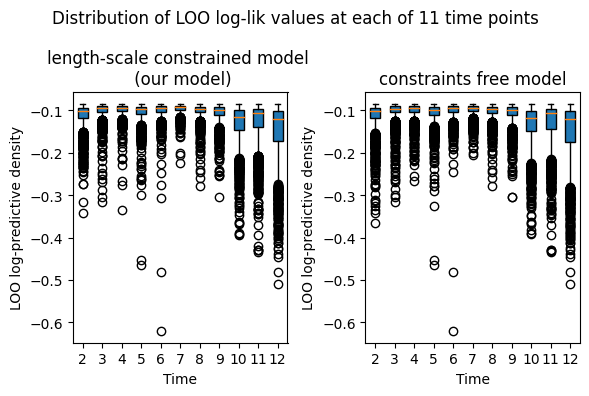

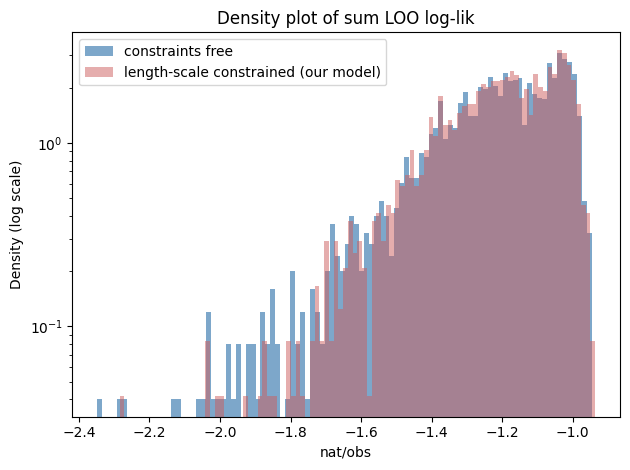

length-scale constrained model: avg (LOO log-lik):-1.2190836100150644
constraints free model: avg (LOO log-lik):-1.2341093585744674


In [11]:
loo_matrix = np.vstack(GP_LOO_nat)
loo_matrix_no_constr = np.vstack(GP_LOO_nat_no_constr)

fig, ax = plt.subplots(1, 2, figsize=(6, 4))

fig.suptitle("Distribution of LOO log-lik values at each of 11 time points")

ax[0].boxplot(loo_matrix/33, positions=np.arange(2, 13), patch_artist=True)
ax[0].set_title("length-scale constrained model \n (our model)")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("LOO log-predictive density")
ax[0].set_xticks(np.arange(2, 13))      


ax[1].boxplot(loo_matrix_no_constr/33, positions=np.arange(2, 13), patch_artist=True)

ax[1].set_title("constraints free model")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("LOO log-predictive density")
ax[1].set_xticks(np.arange(2, 13))       # label boxes 1‥11

plt.tight_layout()

plt.savefig("box_plot_LOO.pdf")
plt.show()


plt.hist(loo_matrix_no_constr.sum(1)/33, bins = 100, label='constraints free', alpha=0.7, color="steelblue", density=True)
plt.hist(loo_matrix.sum(1)/33, bins = 100, label="length-scale constrained (our model)", alpha=0.5, color="indianred", density=True )

plt.yscale("log")
plt.ylabel("Density (log scale)")
plt.xlabel("nat/obs")
plt.title("Density plot of sum LOO log-lik")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("density_plot_LOO.pdf")

plt.show()

print(f"length-scale constrained model: avg (LOO log-lik):{loo_matrix.sum()/(33*1780)}")
print(f"constraints free model: avg (LOO log-lik):{loo_matrix_no_constr.sum()/(33*1780)}")

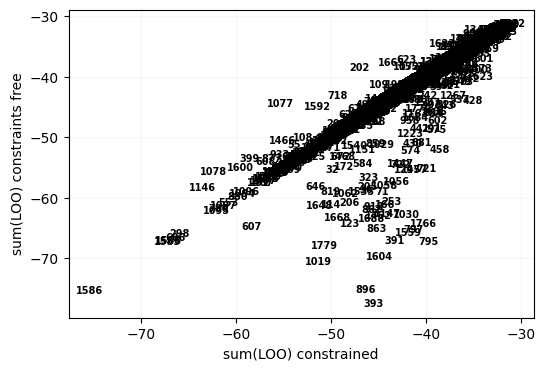

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))

# bigger, filled circles make the text easier to read
ax.scatter(loo_matrix.sum(1), loo_matrix_no_constr.sum(1), s=5, color="#1f77b4", edgecolor="none", alpha=0.2)
lbl = [i+1 for i in range(1780)]
# put each label at the same (x, y) with centered alignment
for xi, yi, lab in zip(loo_matrix.sum(1), loo_matrix_no_constr.sum(1),  lbl):
    ax.text(
        xi,
        yi,
        lab,
        ha="center",
        va="center",
        fontsize=7,
        color="black",      # stands out on the blue markers
        fontweight="bold",
    )

ax.set_xlabel("sum(LOO) constrained")
ax.set_ylabel("sum(LOO) constraints free")
#ax.set_title("Scatter plot with labels inside markers")
ax.grid(True, alpha=0.1)

#plt.tight_layout()
plt.show()


# Synthetic data generation

In [16]:
import scipy

time_points = np.array([[e] for e in list(np.arange(2, 12.25, 0.25))])

trials = pd.DataFrame(columns = ['0%', '10%', '20%', '25%', '30%'])

noisy_genes_prcnt = [0, 0.10, 0.20, 0.25, 0.30] 

tp = np.array([[e] for e in list(np.arange(2, 12.25, 0.25))])

predictions_all = {0:[] , 0.10:[], 0.20:[], 0.25:[], 0.30:[]}

no_genes = target_experiments.shape[0]


for _ in range(5):
    accuracy = []
    for n in noisy_genes_prcnt:
        log_probability_matrix = np.zeros((0,len(tp),5*41))
        micro_array_data_csv1 = target_experiments.T.iloc[0:0].copy()
        modify = target_experiments.T.columns.values

        np.random.shuffle(modify)
        modify = modify[:int(no_genes*n)]

        for gene, ind in zip(common_genes, range(no_genes)):

            means, variances = gp_models[gene].predict(tp)

            if gene in modify:
                
                Y = np.array([[a] for a in reference_time_series.loc[gene]])
                    
                micro_array_data_csv1[gene] = np.concatenate(([np.random.normal(np.mean(Y), (np.var(Y)**0.5), 5) for i in range(41)]))

            else:
                micro_array_data_csv1[gene] = np.concatenate(([np.random.normal(means[i], variances[i]**0.5, 5) for i in range(41)]))
        
       
        for gene, ind in zip(common_genes, range(no_genes)):
            
            means, variances = gp_models[gene].predict(tp)
            
            log_densities = scipy.stats.norm(means, np.sqrt(variances)).logpdf(micro_array_data_csv1[gene])
            log_probability_matrix = np.insert(log_probability_matrix, ind, log_densities, axis=0)


        found = []

        diff = (list(set(tp.flatten()) - set(time_points.flatten())))
        predictions1 = [] 

        matrix = np.delete(log_probability_matrix, [list(tp).index(l) for l in diff], axis=1)

        for i in range(0,log_probability_matrix.shape[2]):       

            max_sum_index = matrix[:,:,i].sum(axis=0).argmax()
            predictions1.append(tp[max_sum_index][0])

            found.append(tp[int(i/5)][0] == tp[max_sum_index][0])

        [predictions_all[n].append(p) for p in predictions1]
        
        print("{}% distorted accuracy: {}".format(n*100, {np.mean(found)}))
        
        accuracy.append(np.mean(found))
        

    #trials = trials.append({'0%' : accuracy[0], '10%' : accuracy[1], '20%' : accuracy[2], '25%' : accuracy[3], '30%' : accuracy[4]}, ignore_index = True)


    trials = pd.concat([trials, 
pd.DataFrame([{'0%' : accuracy[0], '10%' : accuracy[1], '20%' : accuracy[2], '25%' : accuracy[3], '30%' : accuracy[4]}])], ignore_index=True)
####################################################################################
print(trials)
exp_no=5

true_predictions = [tp[int(i/5)][0] for i in range(log_probability_matrix.shape[2])]*exp_no

tolerance = np.array([[e] for e in list(np.arange(0, 1.25, 0.25))])

diff_0 = np.abs(np.array(true_predictions) - np.array(predictions_all[0]))
diff_0 = [np.count_nonzero(diff_0 <= a)/(205*exp_no) for a in tolerance]

diff_25 = np.abs(np.array(true_predictions) - np.array(predictions_all[0.10]))
diff_25 = [np.count_nonzero(diff_25 <= a)/(205*exp_no) for a in tolerance]

diff_50 = np.abs(np.array(true_predictions) - np.array(predictions_all[0.2]))
diff_50= [np.count_nonzero(diff_50 <= a)/(205*exp_no) for a in tolerance]

diff_75 = np.abs(np.array(true_predictions) - np.array(predictions_all[0.25]))
diff_75 = [np.count_nonzero(diff_75 <= a)/(205*exp_no) for a in tolerance]

diff_100 = np.abs(np.array(true_predictions) - np.array(predictions_all[0.3]))
diff_100 = [np.count_nonzero(diff_100 <= a)/(205*exp_no) for a in tolerance]


0% distorted accuracy: {1.0}
10.0% distorted accuracy: {0.8975609756097561}
20.0% distorted accuracy: {0.47317073170731705}
25.0% distorted accuracy: {0.4146341463414634}
30.0% distorted accuracy: {0.3121951219512195}
0% distorted accuracy: {1.0}
10.0% distorted accuracy: {0.6926829268292682}
20.0% distorted accuracy: {0.5121951219512195}
25.0% distorted accuracy: {0.3463414634146341}
30.0% distorted accuracy: {0.375609756097561}
0% distorted accuracy: {1.0}
10.0% distorted accuracy: {0.7560975609756098}
20.0% distorted accuracy: {0.47804878048780486}
25.0% distorted accuracy: {0.4292682926829268}
30.0% distorted accuracy: {0.3902439024390244}
0% distorted accuracy: {1.0}
10.0% distorted accuracy: {0.6487804878048781}
20.0% distorted accuracy: {0.4195121951219512}
25.0% distorted accuracy: {0.375609756097561}
30.0% distorted accuracy: {0.3804878048780488}
0% distorted accuracy: {1.0}
10.0% distorted accuracy: {0.8292682926829268}
20.0% distorted accuracy: {0.4634146341463415}
25.0% dis

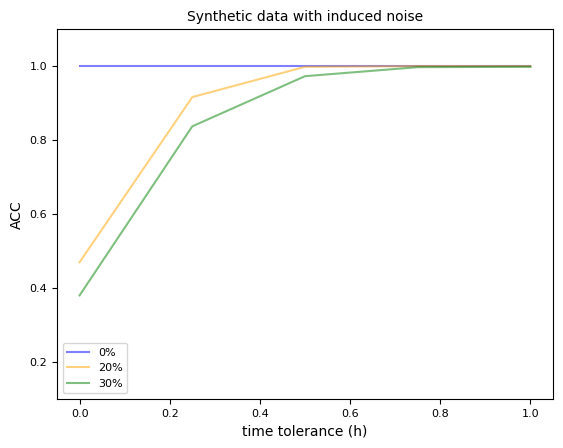

In [17]:
plt.title("Synthetic data with induced noise", fontsize=10)
plt.xlabel("time tolerance (h)",fontsize=10)
plt.ylabel("ACC",fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylim(0.1,1.1)
plt.plot(tolerance, diff_0, "blue", label="0%", alpha=0.5)
plt.plot(tolerance, diff_50, "orange", label="20%", alpha=0.5)
plt.plot(tolerance, diff_100, "green", label="30%", alpha=0.5)
plt.legend(fontsize=8)
plt.savefig("synthetic_data_accuracy.pdf", bbox_inches='tight')

# Accuracy on sparse RNA-Seq experiments

In [18]:
import copy
import scipy
from decimal import Decimal
import math

train_data =  pd.read_csv("one_gene_operon_rna-seq_sparse_train.csv", index_col=0)

test_data = pd.read_csv("one_gene_operon_rna-seq_sparse_test.csv", index_col=0)

test_data = np.log(test_data+0.1)

train_data, test_data, common_genes = data_preprocessing_procedure(train_data, test_data, epsilon_tukey=10**(-10))

In [19]:
train_tp = [2, 4, 6, 8, 10, 12]

X = np.array([[el] for el in train_tp]*3)

tp = np.array([[e] for e in list(np.arange(2, 12.25, 0.25))]) 

log_probability_matrix = np.zeros((0,len(tp), test_data.shape[1]))

for gene, ind in zip(test_data.index, range(0, test_data.index.shape[0])):

    Y = np.array([[a] for a in train_data.loc[gene]])
    
    kernel = GPy.kern.RBF(input_dim=1, variance=0.5, lengthscale=4, useGPU=False)

    kernel.lengthscale.constrain_bounded(lower = 2, upper = 12, warning=0)
    
    m = GPy.models.GPRegression(X,Y,kernel)
    
    m.optimize(messages=False)
    
    means, variances = m.predict(tp)
    
    log_densities = scipy.stats.norm(means, np.sqrt(variances)).logpdf(test_data.loc[gene])
    
    log_probability_matrix = np.insert(log_probability_matrix, ind, log_densities, axis=0)
    


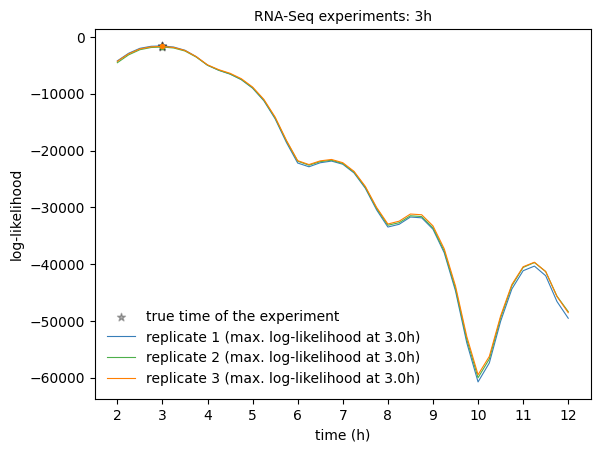

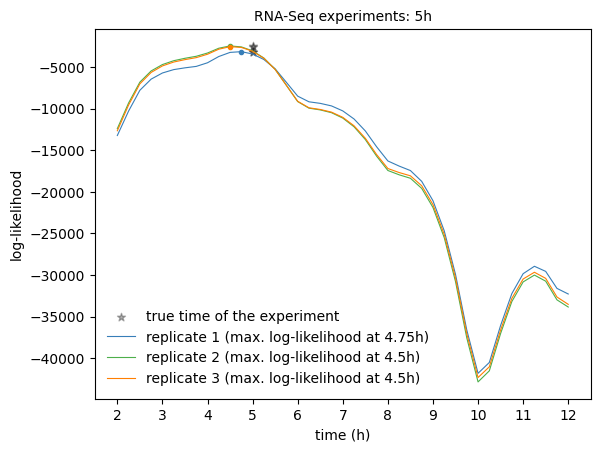

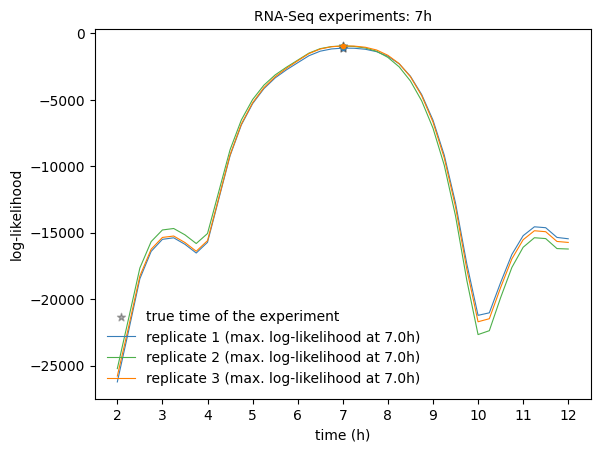

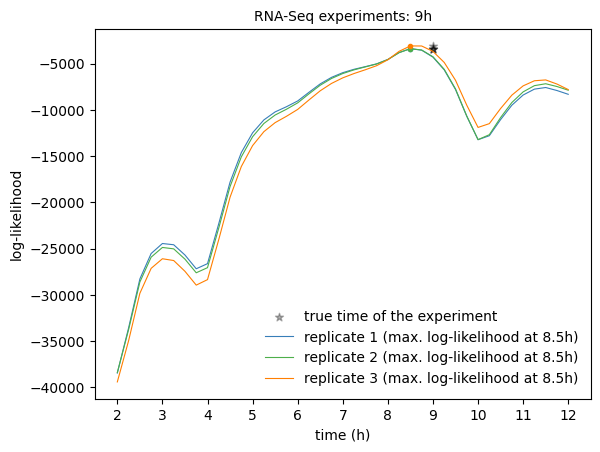

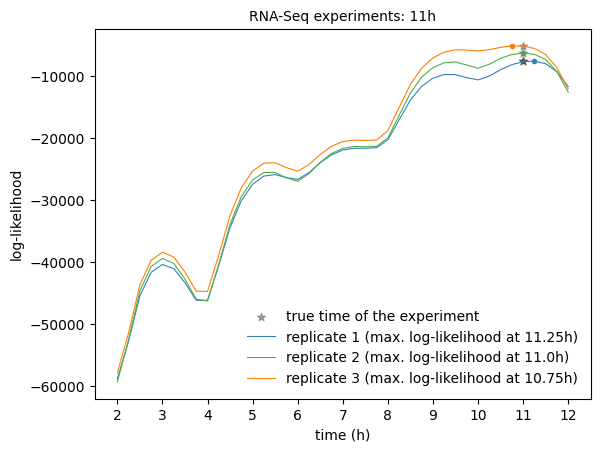

In [20]:
tp = np.array([[round(e,2)] for e in list(np.arange(2, 12.25, 0.25))]) # length: 89

TIME_POINTS = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

time_points = np.array([[2], [2.25],[2.5],[2.75], [3], [3.25],[3.5],[3.75], [4], 
                        [4.25], [4.5], [4.75], [5], [5.25], [5.5], [5.75],
                        [6], [6.25], [6.5], [6.75], [7], [7.25], [7.5], [7.75], [8],
                        [8.25], [8.5], [8.75], [9], [9.25], [9.5], [9.75], [10], [10.25], [10.5], [10.75],
                        [11], [11.25], [11.5], [11.75], [12]]).flatten()


colors = ['#377eb8', '#4daf4a', '#ff7f00']

diff = list(set(tp.flatten()) - set(time_points))

predictions_sparse = []    

matrix = np.delete(log_probability_matrix, [list(tp).index(l) for l in diff], axis=1)

for i in range(0,test_data.shape[1]):
    
    phase = test_data.columns[i]
    
    max_sum_index =  matrix[:,:,i].sum(axis=0).argsort() #[max_likelihood_neighbour_arg_maxima(matrix[:,:,i].sum(axis=0))]

    predictions_sparse.append(time_points[max_sum_index[-1]])

    if i%3 == 0:
        plt.xlabel('time (h)', fontsize=10)
        plt.ylabel('log-likelihood', fontsize=10)
        plt.xticks(TIME_POINTS)
        plt.scatter(int(phase[:-1]), matrix[:,:,i].sum(axis=0)[max_sum_index[-1]], marker='*', c='black', alpha=0.3, label="true time of the experiment")

    plt.plot(time_points, matrix[:,:,i].sum(axis=0), label="replicate {} (max. log-likelihood at {}h)".format((i%3) + 1, time_points[max_sum_index[-1]]), linewidth=0.8, c= colors[i%3])
    
    plt.plot(time_points[max_sum_index[-1]], matrix[:,:,i].sum(axis=0)[max_sum_index[-1]], marker='.', c=colors[i%3])
    
    plt.scatter(int(phase[:-1]), matrix[:,:,i].sum(axis=0)[max_sum_index[-1]], marker='*', c='black', alpha=0.3)
    
    if i%3 == 2:
        plt.title("RNA-Seq experiments: {}h".format(phase[:-1]), fontsize=10)
        plt.legend(fontsize="10", frameon=False)
        plt.show()
             

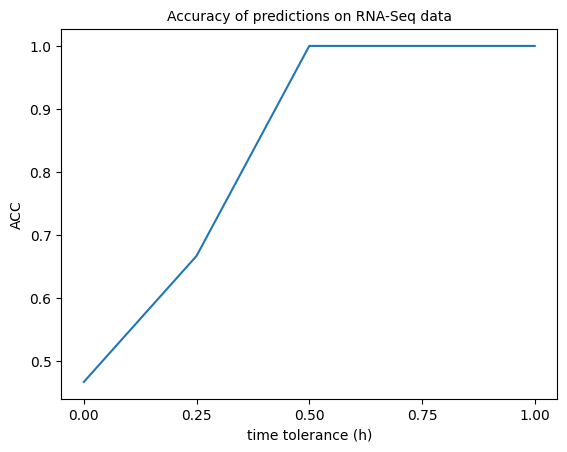

In [21]:
tolerance = [0.0, 0.25, 0.5, 0.75, 1.0]
correct = np.array([int(t[:-1]) for t in test_data.columns])
predicted = np.array(predictions_sparse)

accuracy = [ sum(np.abs(predicted - correct)==0.0)/15, sum(np.abs(predicted - correct)<=0.25)/15, sum(np.abs(predicted - correct)<=0.5)/15,
              sum(np.abs(predicted - correct)<=0.75)/15,  sum(np.abs(predicted - correct)<=1.0)/15]


plt.title("Accuracy of predictions on RNA-Seq data", fontsize=10)
plt.xticks([0,0.25,0.5,0.75,1])


plt.xlabel("time tolerance (h)", fontsize=10)
plt.ylabel("ACC", fontsize=10)
plt.plot(tolerance, accuracy)
plt.show()

# Accuracy on leave-one-replicate-out

In [22]:
import scipy

train_data =  pd.read_csv("one_gene_operon_rna-seq_replicate_train.csv", index_col=0)

test_data = pd.read_csv("one_gene_operon_rna-seq_replicate_test.csv", index_col=0)

test_data = np.log(test_data+0.1)

train_data, test_data, common_genes = data_preprocessing_procedure(train_data, test_data, epsilon_tukey=10**(-10))

In [23]:
train_tp = [2,3,4,5,6,7,8,9,10,11,12]

X = np.array([[el] for el in train_tp]*2)

tp = np.array([[e] for e in list(np.arange(2, 12.25, 0.25))]) 

log_probability_matrix = np.zeros((0,len(tp), test_data.shape[1]))

for gene, ind in zip(test_data.index, range(0, test_data.index.shape[0])):

    Y = np.array([[a] for a in train_data.loc[gene]])
    
    kernel = GPy.kern.RBF(input_dim=1, variance=0.5, lengthscale=4)
    
    kernel.lengthscale.constrain_bounded(lower = 2, upper = 12, warning=0)
    
    m = GPy.models.GPRegression(X,Y,kernel)
    
    m.optimize(messages=False)
    
    means, variances = m.predict(tp)
    
    log_densities = scipy.stats.norm(means, np.sqrt(variances)).logpdf(test_data.loc[gene])
   
    log_probability_matrix = np.insert(log_probability_matrix, ind, log_densities, axis=0)

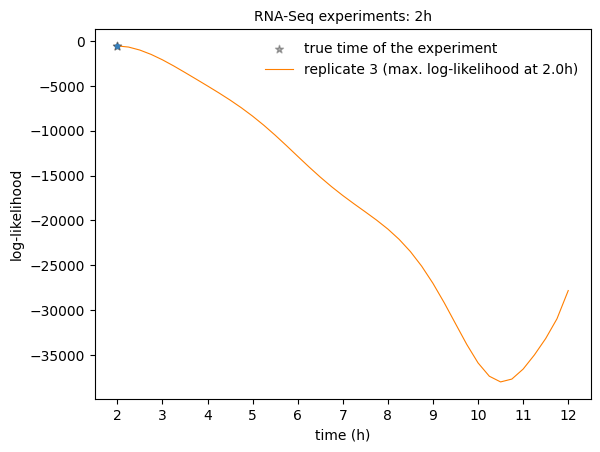

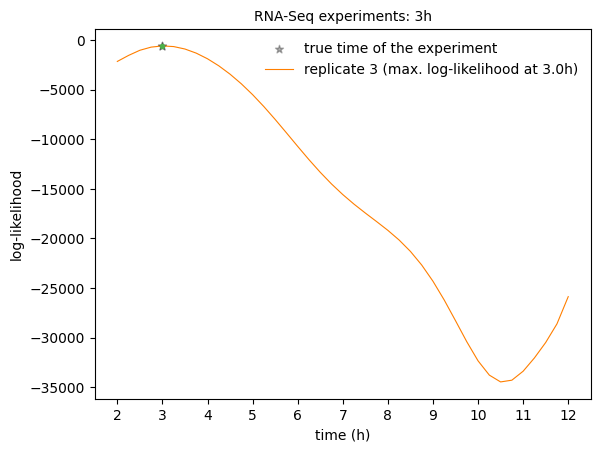

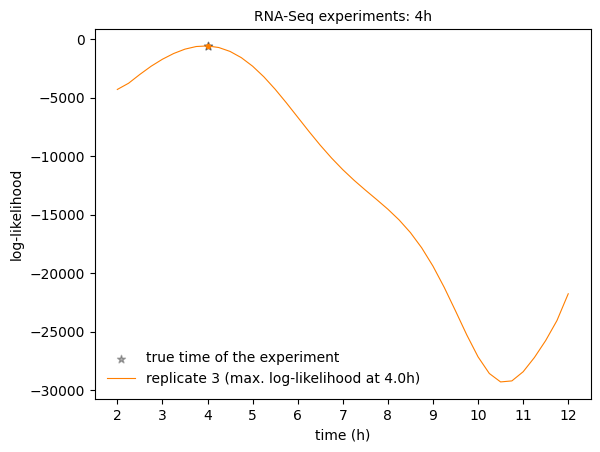

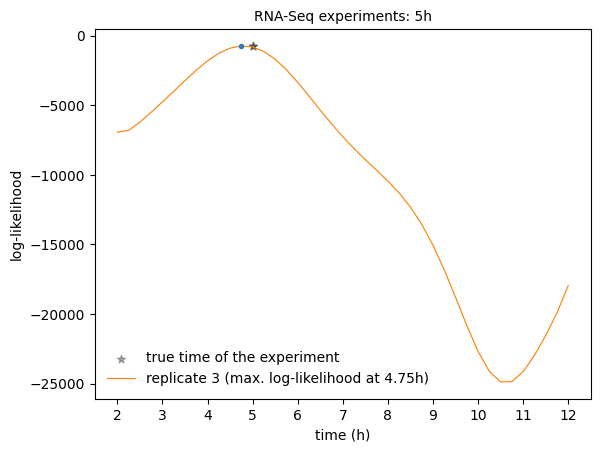

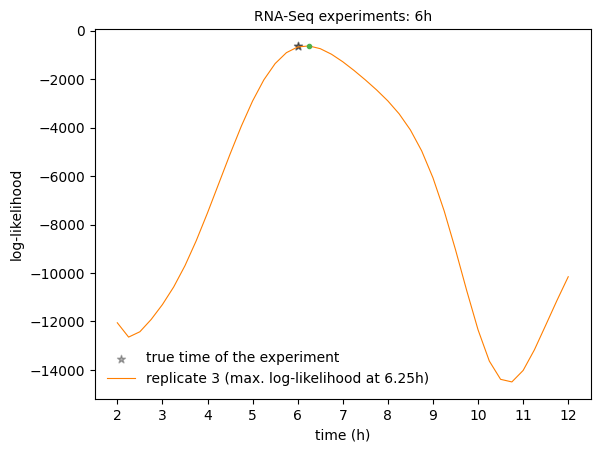

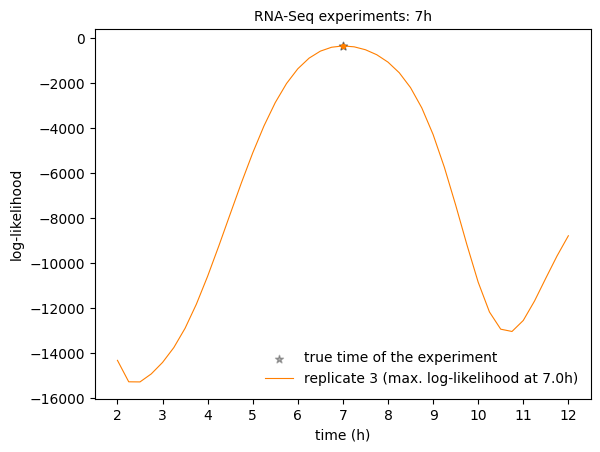

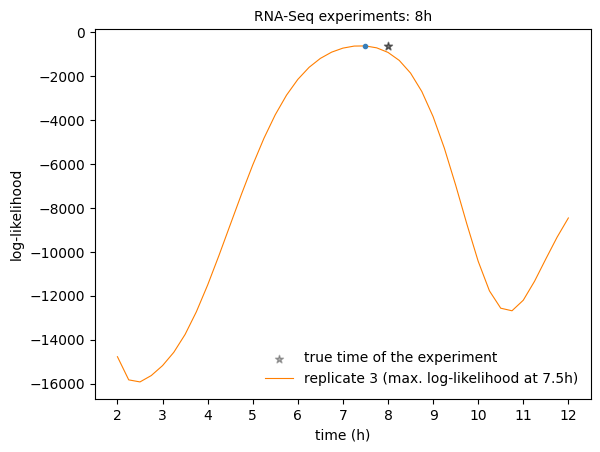

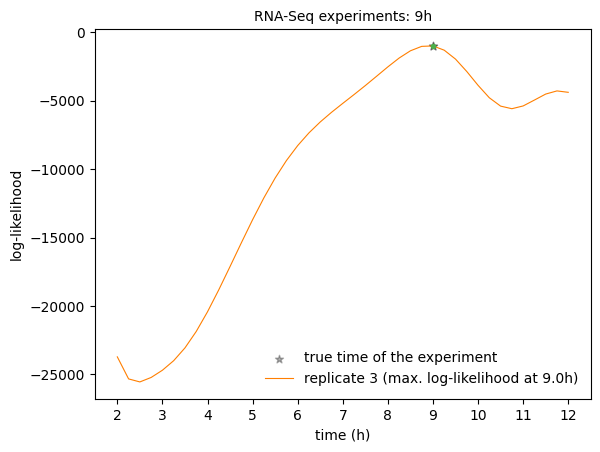

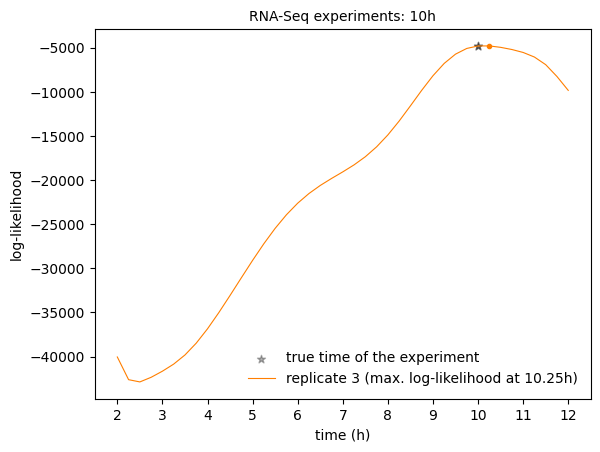

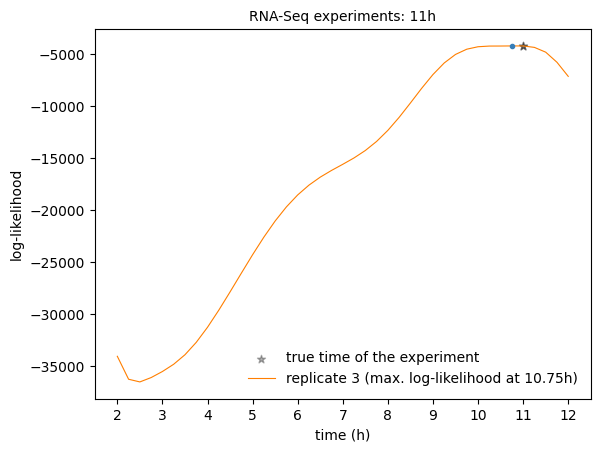

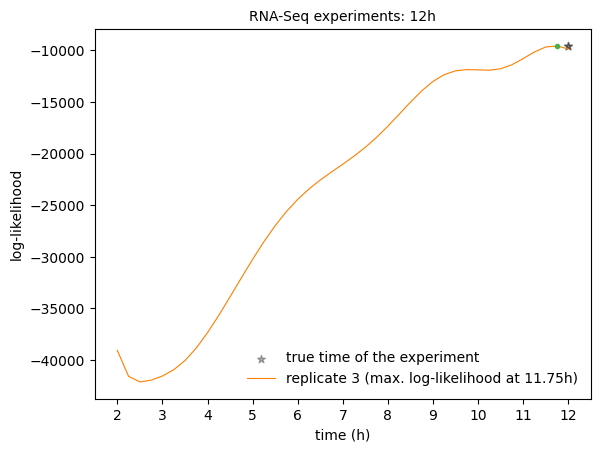

In [24]:
tp = np.array([[round(e,2)] for e in list(np.arange(2, 12.25, 0.25))]) # length: 89
TIME_POINTS = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

time_points = np.array([[2], [2.25],[2.5],[2.75], [3], [3.25],[3.5],[3.75], [4], 
                        [4.25], [4.5], [4.75], [5], [5.25], [5.5], [5.75],
                        [6], [6.25], [6.5], [6.75], [7], [7.25], [7.5], [7.75], [8],
                        [8.25], [8.5], [8.75], [9], [9.25], [9.5], [9.75], [10], [10.25], [10.5], [10.75],
                        [11], [11.25], [11.5], [11.75], [12]]).flatten()


colors = ['#377eb8', '#4daf4a', '#ff7f00']

predictions_sparse = []

diff = list(set(tp.flatten()) - set(time_points))

matrix = np.delete(log_probability_matrix, [list(tp).index(l) for l in diff], axis=1)

for i in range(0,test_data.shape[1]):
    
    phase = test_data.columns[i]
    
    max_sum_index =  matrix[:,:,i].sum(axis=0).argsort()

    predictions_sparse.append(time_points[max_sum_index[-1]])

    
    plt.xlabel('time (h)', fontsize=10)
    plt.ylabel('log-likelihood', fontsize=10)
    plt.xticks(TIME_POINTS)
    plt.scatter(int(phase[:-1]), matrix[:,:,i].sum(axis=0)[max_sum_index[-1]], marker='*', c='black', alpha=0.3, label="true time of the experiment")
    
    plt.plot(time_points, matrix[:,:,i].sum(axis=0), label="replicate {} (max. log-likelihood at {}h)".format(3, time_points[max_sum_index[-1]]), linewidth=0.8, c= colors[2])
    
    plt.plot(time_points[max_sum_index[-1]], matrix[:,:,i].sum(axis=0)[max_sum_index[-1]], marker='.', c=colors[i%3])
    
    plt.scatter(int(phase[:-1]), matrix[:,:,i].sum(axis=0)[max_sum_index[-1]], marker='*', c='black', alpha=0.3)

    plt.title("RNA-Seq experiments: {}h".format(phase[:-1]), fontsize=10)
    plt.legend(fontsize="10", frameon=False)
      
    plt.show()
    


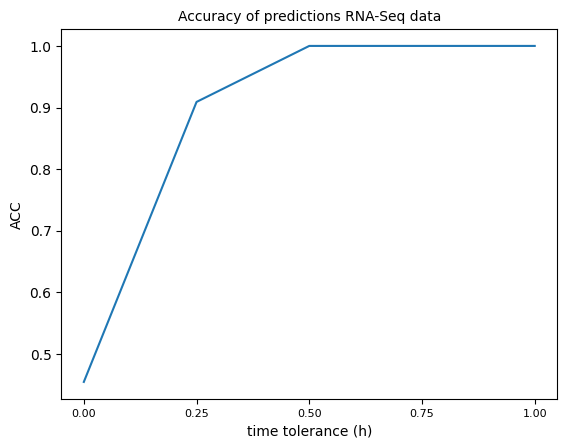

In [25]:
tolerance = [0.0, 0.25, 0.5, 0.75, 1.0]
correct = np.array([int(t[:-1]) for t in test_data.columns])
predicted = np.array(predictions_sparse)

accuracy = [ sum(np.abs(predicted - correct)==0.0)/11, sum(np.abs(predicted - correct)<=0.25)/11, sum(np.abs(predicted - correct)<=0.5)/11,
              sum(np.abs(predicted - correct)<=0.75)/11,  sum(np.abs(predicted - correct)<=1.0)/11]


plt.title("Accuracy of predictions RNA-Seq data", fontsize=10)
plt.xticks([0,0.25,0.5,0.75,1], fontsize=8)

plt.xlabel("time tolerance (h)", fontsize=10)
plt.ylabel("ACC", fontsize=10)
plt.plot(tolerance, accuracy)
plt.show()

# Differential expression analysis of microarray data

## Simulation of DE analysis with added noise

In [26]:
import sys
import click
import pandas as pd
import rpy2.robjects as ro
from rpy2.rinterface_lib.embedded import RRuntimeError
from rpy2.robjects import pandas2ri, Formula
from rpy2.robjects.conversion import localconverter
import matplotlib.pyplot as plt
from rpy2.robjects.packages import importr
import numpy as np


def DE_genes(data, design, growth_phase_1, growth_phase_2):
    
        #Import R libraries
        base = importr('base')
        stats = importr('stats')
        limma = importr('limma')#, lib_loc='path to the downloaded R package limma')
        writexl = importr('writexl')#, lib_loc='path to the downloaded R package writexl')
            
        # Convert data and design pandas dataframes to R dataframes
        with localconverter(ro.default_converter + pandas2ri.converter):
            r_data = ro.conversion.py2rpy(data) #ro.conversion.py2ri(data)
            r_design = ro.conversion.py2rpy(design) #ro.conversion.py2ri(design)
            # Use the genes index column from data as a R String Vector
            genes = ro.StrVector(
                [
                    str(index)
                    #added tovalues to convert to numpy array
                    for index in data.index.tolist()
                ]
            )
        
        # Create a model matrix using design's Target column using the R formula "~0 + f" to get all the unique factors as columns
        f = base.factor(r_design.rx2('Target'), levels=base.unique(r_design.rx2('Target')))
        form = Formula('~0 + f')
        form.environment['f'] = f
        r_design = stats.model_matrix(form)
        r_design.colnames = base.levels(f)
        
        # Fit the data to the design using lmFit from limma
        fit = limma.lmFit(r_data, r_design)
        # Make a contrasts matrix with the 1st and the last unique values
        contrast_matrix = limma.makeContrasts(f'{growth_phase_2}-{growth_phase_1}', levels=r_design)
        
        # Fit the contrasts matrix to the lmFit data & calculate the bayesian fit
        fit2 = limma.contrasts_fit(fit, contrast_matrix)
        fit2 = limma.eBayes(fit2)
        
        # topTreat the bayesian fit using the contrasts and add the genelist
        r_output = limma.topTreat(fit2, coef=1, genelist=genes, number=np.Inf)
        
        writexl.write_xlsx(r_output, "annotation_data/limma_output_new.xlsx")
        df_new = pd.read_excel('annotation_data/limma_output_new.xlsx', index_col=0)
        
        
        ###########################################################################################
        significant_df = df_new.loc[df_new['adj.P.Val']<0.05]
        
        ###########################################################################################
        logFC = [i/10 for i in range(100)]
        
        return [significant_df.loc[significant_df['logFC'].abs() > i ].shape[0] for i in logFC ]
    


def noise_induced_DE_analysis(growth_phase_1, growth_phase_2, noise_level):
    GP_curve_mislabeled = np.array([0]*100)
    
    # Load expression matrix
    data = pd.read_csv('annotation_data/counts_{}_{}_gp_filtered_raw.csv'.format(growth_phase_1,growth_phase_2), index_col=0)#.loc[good_genes]
    
    for i in range (100):
        # Load metadata
        design = pd.read_csv('annotation_data/metadata_{}_{}_gp_filtered_raw.csv'.format(growth_phase_1,growth_phase_2), index_col=0)
        
        #design["Target"] = design.iloc[np.random.permutation(len(design))]["Target"].values
        col = design.columns[0]             
        # 1. Pick 20 % of the row labels at random (without replacement)
        subset_idx = design.sample(frac=noise_level).index
        # 2. Grab the values at those rows and shuffle them
        shuffled_vals = np.random.permutation(design.loc[subset_idx, col].values)
        # 3. Put the shuffled values back into the *same* rows
        design.loc[subset_idx, col] = shuffled_vals
        
        ####################
        
        b = DE_genes(data, design, growth_phase_1, growth_phase_2)
        ###########################################################################################
        GP_curve_mislabeled = np.array(b) + GP_curve_mislabeled

    return GP_curve_mislabeled

    
phase1='early'
phase2='mid'

GP_curve_mislabeled_40 = noise_induced_DE_analysis(phase1, phase2, 0.4)

GP_curve_mislabeled_35 = noise_induced_DE_analysis(phase1, phase2, 0.35)

data = pd.read_csv('annotation_data/counts_{}_{}_old_raw.csv'.format(phase1,phase2), index_col=0)
design = pd.read_csv('annotation_data/metadata_{}_{}_old_raw.csv'.format(phase1,phase2), index_col=0)

Old_curve = DE_genes(data, design, phase1, phase2)

data = pd.read_csv('annotation_data/counts_{}_{}_gp_filtered_raw.csv'.format(phase1,phase2), index_col=0)
design = pd.read_csv('annotation_data/metadata_{}_{}_gp_filtered_raw.csv'.format(phase1,phase2), index_col=0)

GP_curve = DE_genes(data, design, phase1, phase2)

 /opt/anaconda3/envs/rpy2_venv/lib/python3.8/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning:Environment variable "PWD" redefined by R and overriding existing variable. Current: "/Users/nushelio", R: "/Users/nushelio/Downloads/LOO cross validation"
 /opt/anaconda3/envs/rpy2_venv/lib/python3.8/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning:Environment variable "R_SESSION_TMPDIR" redefined by R and overriding existing variable. Current: "/var/folders/93/vbpjhrnd1jb328c120ly4y514gdft6/T//RtmpgFBFhi", R: "/var/folders/93/vbpjhrnd1jb328c120ly4y514gdft6/T//RtmpAozyGZ"


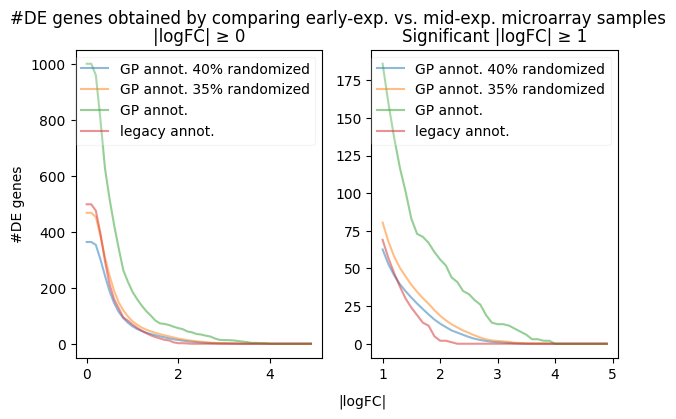

In [27]:
###################

logFC = [i/10 for i in range(100)]

fig = plt.figure(figsize=(7, 4))
fig.text(0.5, 0, '|logFC|', va='center', rotation='horizontal')
plt.suptitle('#DE genes obtained by comparing early-exp. vs. mid-exp. microarray samples')

plt.subplot(1, 2, 1)
plt.ylabel('#DE genes')
plt.title(f'|logFC| ≥ 0')

up = 50
low = 0

plt.plot(logFC[low:up], GP_curve_mislabeled_40[low:up]/100, label='GP annot. 40% randomized', alpha=0.5)
plt.plot(logFC[low:up], GP_curve_mislabeled_35[low:up]/100, label='GP annot. 35% randomized', alpha=0.5)
plt.plot(logFC[low:up], GP_curve[low:up], label='GP annot.', alpha=0.5)
plt.plot(logFC[low:up], Old_curve[low:up], label='legacy annot.', alpha=0.5)
plt.legend(loc='best', framealpha=0.2)


plt.subplot(1, 2, 2)
plt.title(f'Significant |logFC| ≥ 1')

up = 50
low = 10

plt.plot(logFC[low:up], GP_curve_mislabeled_40[low:up]/100, label='GP annot. 40% randomized', alpha=0.5)
plt.plot(logFC[low:up], GP_curve_mislabeled_35[low:up]/100, label='GP annot. 35% randomized', alpha=0.5)
plt.plot(logFC[low:up], GP_curve[low:up], label='GP annot.', alpha=0.5)
plt.plot(logFC[low:up], Old_curve[low:up], label='legacy annot.', alpha=0.5)
plt.legend(loc='best', framealpha=0.2)

plt.savefig("DE_analysis_suppl.pdf", bbox_inches='tight')

plt.show()

## DE analysis: comparison between GP-based, KNN and original growth phase annotations

In [28]:
KNN_curve = np.array([0]*100)
Old_curve = np.array([0]*100)
GP_curve = np.array([0]*100)

phase1 = ['early','mid','late','transition']
phase2 = ['mid', 'late', 'transition', 'stationary']

for ph1, ph2 in zip(phase1, phase2):

    data = pd.read_csv('annotation_data/counts_{}_{}_old_raw.csv'.format(ph1,ph2), index_col=0)
    design = pd.read_csv('annotation_data/metadata_{}_{}_old_raw.csv'.format(ph1,ph2), index_col=0)
    Old_curve = np.array(DE_genes(data, design, ph1, ph2)) + Old_curve

    data = pd.read_csv('annotation_data/counts_{}_{}_gp_filtered_raw.csv'.format(ph1,ph2), index_col=0)#.loc[good_genes]
    design = pd.read_csv('annotation_data/metadata_{}_{}_gp_filtered_raw.csv'.format(ph1,ph2), index_col=0)
    GP_curve = np.array(DE_genes(data, design, ph1, ph2)) + GP_curve

    data = pd.read_csv('annotation_data/counts_{}_{}_knn_raw.csv'.format(ph1,ph2), index_col=0)
    design = pd.read_csv('annotation_data/metadata_{}_{}_knn_raw.csv'.format(ph1,ph2), index_col=0)
    KNN_curve = np.array(DE_genes(data, design, ph1, ph2)) + KNN_curve
    

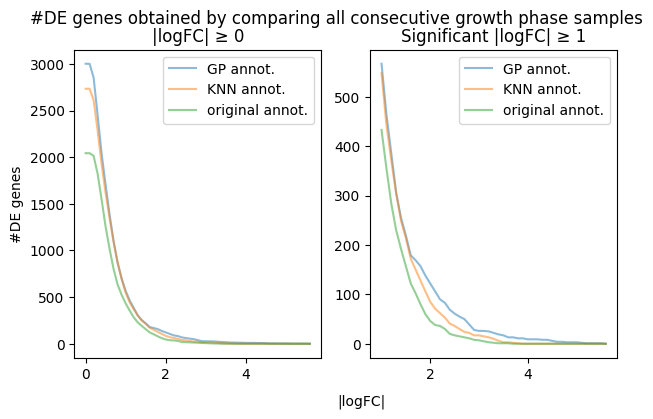

In [29]:
###################
fig = plt.figure(figsize=(7, 4))
fig.text(0.5, 0, '|logFC|', va='center', rotation='horizontal')
plt.suptitle('#DE genes obtained by comparing all consecutive growth phase samples')


plt.subplot(1, 2, 1)
plt.ylabel('#DE genes')
plt.title(f'|logFC| ≥ 0')

up = 57
low = 0

plt.plot(logFC[low:up], GP_curve[low:up], label='GP annot.', alpha=0.5)
plt.plot(logFC[low:up], KNN_curve[low:up], label='KNN annot.', alpha=0.5)
plt.plot(logFC[low:up], Old_curve[low:up], label='original annot.', alpha=0.5)
plt.legend()

plt.subplot(1, 2, 2)

plt.title(f'Significant |logFC| ≥ 1')


up = 57
low = 10

plt.plot(logFC[low:up], GP_curve[low:up], label='GP annot.', alpha=0.5)
plt.plot(logFC[low:up], KNN_curve[low:up], label='KNN annot.', alpha=0.5)
plt.plot(logFC[low:up], Old_curve[low:up], label='original annot.', alpha=0.5)
plt.legend()

plt.savefig("DE_analysis.pdf", bbox_inches='tight')

plt.show()